In [1]:
import os
import sys

sys.path.insert(0, './Manga-Text-Segmentation/code')
print(sys.path)

from fastai.vision import *
from dataset import *

['./Manga-Text-Segmentation/code', '/home/saratoga/miniforge3/envs/mtl/lib/python311.zip', '/home/saratoga/miniforge3/envs/mtl/lib/python3.11', '/home/saratoga/miniforge3/envs/mtl/lib/python3.11/lib-dynload', '', '/home/saratoga/miniforge3/envs/mtl/lib/python3.11/site-packages']


In [2]:
# im = open_image('images/AisazuNihaIrarenai-009.jpg')
im = open_image('images/shegreat_0020.png')
pred = [0] * 5
for _ in range(5):
    learner = load_learner('models', f'fold.{_}.-.final.refined.model.2.pkl')
    pred[_] = learner.predict(im)[0]

/home/saratoga/miniforge3/envs/mtl/lib/python3.11/site-packages/fastai/basic_train.py:621: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(source, map_locat

In [3]:
total = sum(p.px for p in pred)
# print([p.shape for p in pred])
total[total < 4] = 0.
total[total >= 4] = 1.
# print(im1)

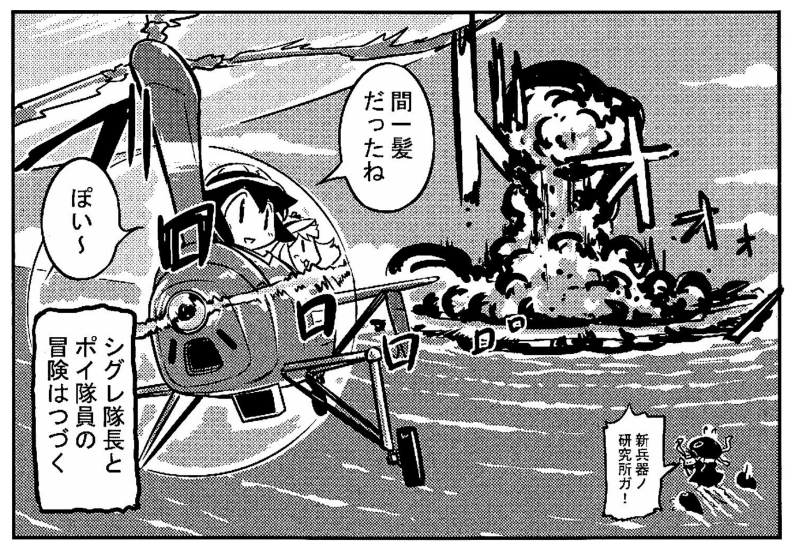

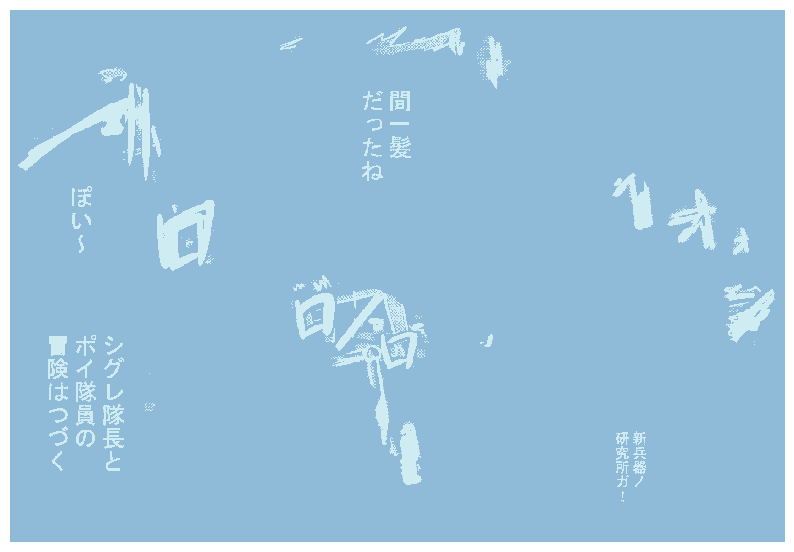

In [4]:
im.show(figsize=(10, 10))
pred[0].show(figsize=(10, 10))
# im.show(y=total, figsize=(22, 22), alpha=0.8)

In [5]:
#given prediction and ground truth, returns colorized tensor with true positives as green, false positives as red and false negative as white
def colorizePrediction(prediction, truth):
    prediction, truth = prediction[0], truth[0]
    colorized = torch.zeros(4, prediction.shape[0], prediction.shape[1]).int()
    r, g, b, a = colorized[:]
    
    fn = (truth >= 1) & (truth <= 5) & (truth != 3) & (prediction == 0)
    tp = ((truth >= 1) & (truth <= 5)) & (prediction >= 1)
    fp = (truth == 0) & (prediction >= 1)
    
    r[fp] = 255
    r[fn] = g[fn] = b[fn] = 255
    g[tp] = 255

    a[:, :] = 128
    a[tp | fn | fp] = 255

    return colorized

/home/saratoga/miniforge3/envs/mtl/lib/python3.11/site-packages/fastai/vision/image.py:20: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1728945388353/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(a.astype(dtype, copy=False) )


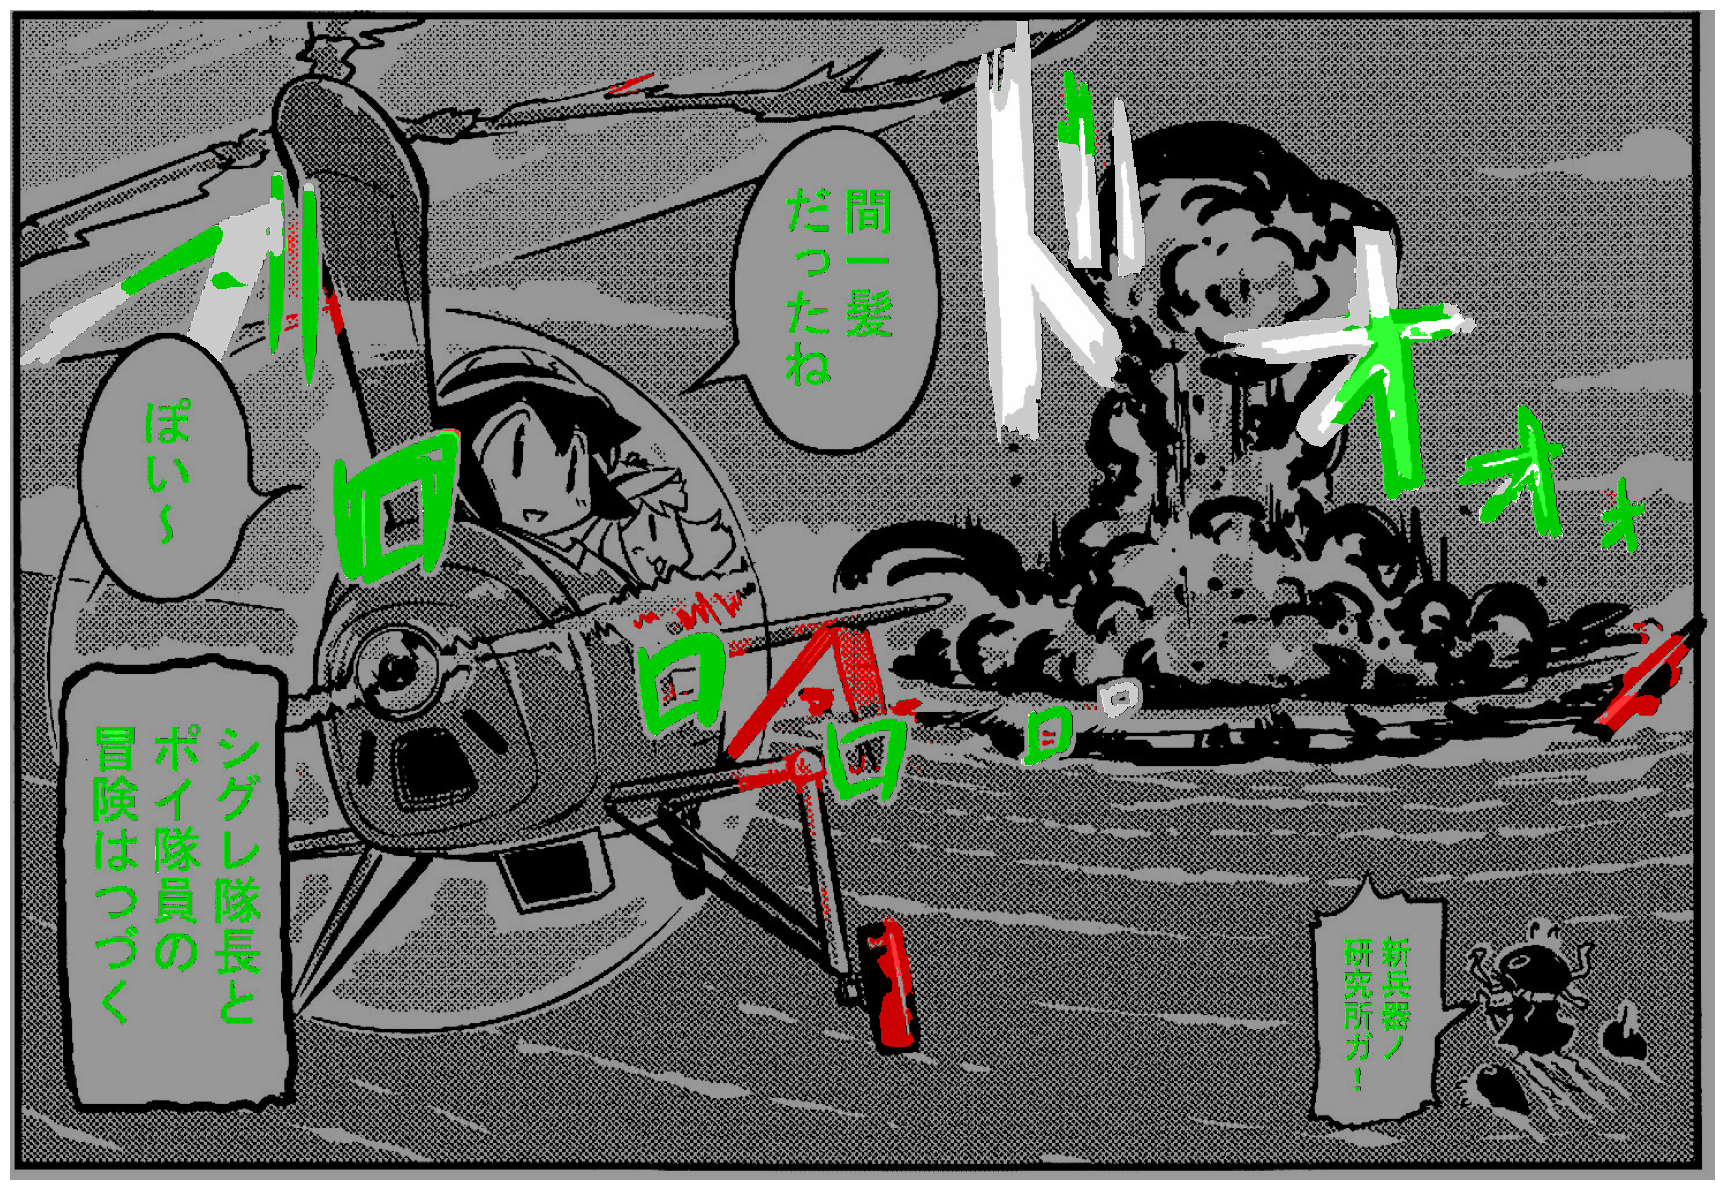

In [6]:
#with truth label, we can get nicer coloring
# assert False, "Force stop"
# images = SegLabelListCustom(['../images/AisazuNihaIrarenaipre-processed-truth-009.png'])
im = open_image('images/shegreat_0020.png')
images = SegLabelListCustom(['images/shegreat_0020_truth.png'])
images.useCached = False
truth = images.get(0, False)
im.show(y = ImageSegment(colorizePrediction(total, truth.px)), figsize=(22, 22), alpha = 0.8)

[(tensor(0.5477), tensor(0.5396), tensor(0.5437)), (tensor(0.6588), tensor(0.4863), tensor(0.5595)), (tensor(0.7283), tensor(0.4382), tensor(0.5472)), (tensor(0.7978), tensor(0.3795), tensor(0.5143)), (tensor(0.8888), tensor(0.2955), tensor(0.4435))]


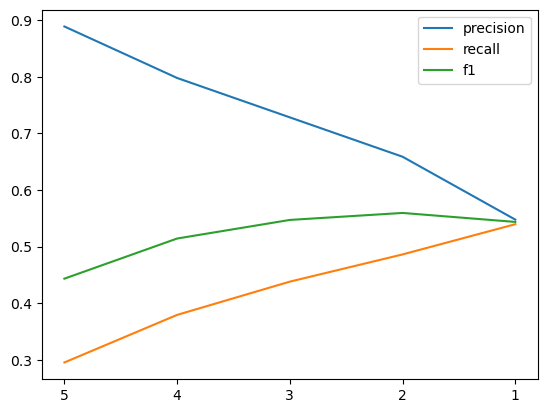

<Figure size 600x600 with 0 Axes>

In [7]:
def score(pred, truth):
    pred, truth = pred[0], truth[0]
    tp = truth[(pred >= 1) & (truth >= 1)].count_nonzero()
    # tn = truth[(pred == 0) & (truth == 0)].count_nonzero()
    fp = pred[(pred >= 1) & (truth == 0)].count_nonzero()
    fn = truth[(truth >= 1) & (pred == 0)].count_nonzero()

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    return (precision, recall, f1)

bench = []
for _ in range(1, 6):
    total = sum(p.px for p in pred)
    # print([p.shape for p in pred])
    total[total < _] = 0.
    bench.append(score(total, truth.px))
    preview = ImageSegment(colorizePrediction(total, truth.px))
    # im.show(y = preview, figsize=(20, 20), alpha = 0.8)
    current = plt.gcf()
    current.canvas.draw()
    width, height = current.canvas.get_width_height()
    image_data = np.frombuffer(current.canvas.buffer_rgba(), dtype=np.uint8).reshape((height, width, 4))
    x_crop_range = (width*6//11, width*39//60)
    y_crop_range = (height//4, height*2//5)
    cropped_image = image_data[y_crop_range[0]:y_crop_range[1], x_crop_range[0]:x_crop_range[1], :]
    
    # plt.imshow(cropped_image)
print(bench)

plt.clf()
plt.plot(list(map(str, range(5, 0, -1))), list(reversed(bench)))
plt.legend(["precision", "recall", "f1"])
plt.figure(figsize=(6, 6))
plt.tight_layout()
plt.show()
